In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

#### dataset

In [2]:
import torchvision 

import torchvision.transforms as transforms 

In [3]:
trainset = torchvision.datasets.CIFAR10(root='../data_place/cifar', 
                                        train=True, 
                                        download=False, 
                                        transform=transforms.ToTensor())


In [4]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# in the dataset this will be in numbers.. class 0,1,2,.. 

#### dataloader

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, #dataset
                                          batch_size=4, 
                                          shuffle=True)

# shuffle = True => they are given randomly.
# if we don't shuffle then sometimes the whole training course become repetitive.

In [6]:
# iterator for dataloader
data_iter = iter(trainloader)

In [7]:
# one batch
images, labels = next(data_iter)

In [8]:
import torch.nn as nn

### Networks with only convolution layers(no activation..)

### single convln layer - model

**nn.Conv2d is an inbuilt model-block-class**

In [9]:
class OneCNNLayer(nn.Module): #inherit nn.Module

    def __init__(self): 
        
        super().__init__() #super with this class as arg??

        self.conv1 = nn.Conv2d(3, 16, 3, 
                               padding=(1,1), 
                               stride=(2,2)) 
        # 3 - number of channels in input (kernel depth)
        # 16 - number of output channels(number of kernels)
        # 3 - kernel size. 3x3. can instead use a tupe (lxw) 
        # (can have rectangular kernels.. )
        # if padding, stride are not mentioned, they will be taken as 0.
        # along row, column

        
    def forward(self, XX):
        XX = self.conv1(XX)
        return XX

**define all network blocks ("model-block objects").. in init -> forward.. only calling..**   
"forward" is necessary for \_\_call__ to work.  

In [10]:
one_cnn_layer = OneCNNLayer() # model_object

## Model Inference  

model is a relation b/w an input- an ouput.  

inference => get ouput, given input.  

this would be something that we do, when we are using a trained model for some application.  
"trained" => the model parameters will be optimal values.

In [11]:
out = one_cnn_layer(images) #calls forward()
# because of __call__

#here : do convoln and return the ouput channels

out.shape

torch.Size([4, 16, 16, 16])

4 x 16 channels x 16 rows x 16 cols  

batch size=4. doing convoln, etc. in parallel to n datapoints(images)  

16 - number of ouput channels   
one channel - 16x16   

with what all kernels?  
those which get inintialised(interanlly) when we do nn.Conv2d.   

**kernel => weights (parameters)**    
model has parameters, forward.   


In [12]:
# kernel = parameters
for param in one_cnn_layer.parameters():
    print(param.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])


### can call model_object.parameters() - for any model_block_object

2 parameteres internally made(wrapped in Parameter()).

one - 16 3x3x3 kernels  
another - 16 biases  
one bias for each kernel.  

**internally many things are happening**

### showing second layer ouput(neuron)

In [12]:
# plot one channel of the outputs of convoln.
# output assigned to 'out'

# out -> 4, 16, 16, 16 (batch, channel, x, y)

out0 = out[0, 0, :, :].detach().numpy() 
# 0th batch, 0th channel
print(out0.shape)

(16, 16)


#### detach

tensor.detach() - Returns a new Tensor **(share the storage with original), detached from the current graph.**  
It detaches the output from the computational graph; So no gradient will be backpropagated along this variable.

In [19]:
# share memeory
aa = torch.ones(2,2)
bb = aa.detach()
bb[0,0] = 2

print(aa)
print(bb)

tensor([[2., 1.],
        [1., 1.]])
tensor([[2., 1.],
        [1., 1.]])


#### Difference between a torch.tensor and np.ndarray:  

While both objects are used to store n-dimensional matrices (aka "Tensors"), torch.tensors has an additional "layer" - which is storing the computational graph leading to the associated n-dimensional matrix.

So, if you are only interested in efficient and easy way to perform mathematical operations on matrices np.ndarray or torch.tensor can be used interchangeably.

However, torch.tensors are designed to be used in the context of gradient descent optimization, and therefore they hold not only a tensor with numeric values, but (and more importantly) the computational graph leading to these values. This computational graph is then used (using the chain rule of derivatives) to compute the derivative of the loss function w.r.t each of the independent variables used to compute the loss.

#### tensor.detach().numpy()

As mentioned before, np.ndarray object does not have this extra "computational graph" layer and therefore, when converting a torch.tensor to np.ndarray you must explicitly remove the computational graph of the tensor using the detach() command.

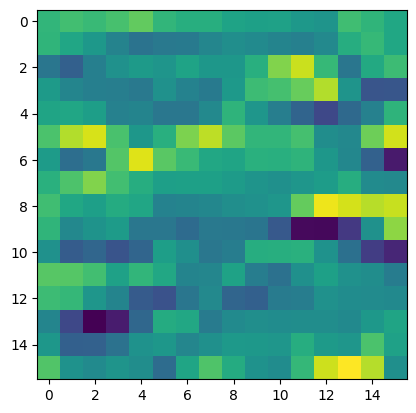

In [13]:
plt.imshow(out0) # not transposing, etc. as its not rgb. only a single channel like a greyscale
plt.show()

some features of the original image can be seen here.. 

### 2 Layer CNN

In [20]:
class TwoCNNLayers(nn.Module):
    def __init__(self): 
        
        super().__init__()

        # two convoln layers
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, 3),   # (N, 3, 32, 32) -> (N, 8, 30, 30)
            nn.Conv2d(8, 16, 3)   # (N, 8, 30, 30) -> (N, 16, 28, 28)
        )
        # first layer - out 8 channels
        # second layer (after it) - input should be 8 channels.
        
    def forward(self, XX):
        XX = self.model(XX)
        return XX

(N, 3, 32, 32) **tracking dimensions**.  
**N = batch size**, etc..   

**while making model - think about one datapoint only. Batch, etc. taken care automatically by broadcasting, etc.**

In [21]:
# inference

two_cnn_layers = TwoCNNLayers()
out = two_cnn_layers(images)

# now out has results after the two layers.

out.shape

# get the shape as we expected.

torch.Size([4, 16, 28, 28])

### Convoln layers with other layers

In [22]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            
            # 2x2 average pooling kernel
            # using stride = 2 so that no overlap
            # this average pool is not the avg pool in GoogleNet.
            # this is avg instead of max.
            
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, XX):
        XX = self.model(XX)
        return XX

In [24]:
cnn_model = CNN()
out = cnn_model(images)
out.shape

torch.Size([4, 16, 5, 5])

above : just doing convoln - one after another - no activation in b/w. as it was not specified